# Wave Function Optimization

We present here a complete example on how to use QMCTorch on a H2 molecule.
We first need to import all the relevant modules :

In [1]:
from torch import optim
from qmctorch.scf import Molecule
from qmctorch.wavefunction import SlaterJastrow
from qmctorch.solver import Solver
from qmctorch.sampler import Metropolis
from qmctorch.utils import set_torch_double_precision
from qmctorch.utils import (plot_energy, plot_data)
set_torch_double_precision()

INFO:QMCTorch|  ____    __  ______________             _
INFO:QMCTorch| / __ \  /  |/  / ___/_  __/__  ________/ /  
INFO:QMCTorch|/ /_/ / / /|_/ / /__  / / / _ \/ __/ __/ _ \ 
INFO:QMCTorch|\___\_\/_/  /_/\___/ /_/  \___/_/  \__/_//_/ 


## Creating the system

The first step is to define a molecule. We here use a H2 molecule with both hydrgen atoms
on the z-axis and separated by 1.38 atomic unit. We choose here to use Slater orbitals that can be otained via `ADF`. We simply here reload calculations to create the molecule

In [2]:
mol = Molecule(load='./hdf5/H2_adf_dzp.hdf5')

INFO:QMCTorch|
INFO:QMCTorch| SCF Calculation
INFO:QMCTorch|  Loading data from ./hdf5/H2_adf_dzp.hdf5


We then define the wave function relative to this molecule. We also specify here
the determinants we want to use in the CI expansion. We use here a to include all the single
and double excitation with 2 electrons and 2 orbitals

In [3]:
wf = SlaterJastrow(mol, configs='single_double(2,2)')

INFO:QMCTorch|
INFO:QMCTorch| Wave Function
INFO:QMCTorch|  Jastrow factor      : True
INFO:QMCTorch|  Jastrow kernel      : PadeJastrowKernel
INFO:QMCTorch|  Highest MO included : 10
INFO:QMCTorch|  Configurations      : single_double(2,2)
INFO:QMCTorch|  Number of confs     : 4
INFO:QMCTorch|  Kinetic energy      : jacobi
INFO:QMCTorch|  Number var  param   : 121
INFO:QMCTorch|  Cuda support        : False


As a sampler we use a simple Metropolis Hasting with 1000 walkers. The walkers are initially localized around the atoms.
Each walker will perform 2000 steps of size 0.2 atomic unit and will only keep the last position of each walker (`ntherm=-1`).
During each move all the the electrons are moved simultaneously within a normal distribution centered around their current location.

In [4]:
sampler = Metropolis(nwalkers=5000,
                     nstep=200, step_size=0.2,
                     ntherm=-1, ndecor=100,
                     nelec=wf.nelec, init=mol.domain('atomic'),
                     move={'type': 'all-elec', 'proba': 'normal'})

INFO:QMCTorch|
INFO:QMCTorch| Monte-Carlo Sampler
INFO:QMCTorch|  Number of walkers   : 5000
INFO:QMCTorch|  Number of steps     : 200
INFO:QMCTorch|  Step size           : 0.2
INFO:QMCTorch|  Thermalization steps: -1
INFO:QMCTorch|  Decorelation steps  : 100
INFO:QMCTorch|  Walkers init pos    : atomic
INFO:QMCTorch|  Move type           : all-elec
INFO:QMCTorch|  Move proba          : normal


We will use the ADAM optimizer implemented in pytorch with custom learning rate for each layer.
We also define a linear scheduler that will decrease the learning rate after 100 steps

In [5]:
lr_dict = [{'params': wf.jastrow.parameters(), 'lr': 1E-2},
           {'params': wf.ao.parameters(), 'lr': 1E-6},
           {'params': wf.mo.parameters(), 'lr': 2E-3},
           {'params': wf.fc.parameters(), 'lr': 2E-3}]
opt = optim.Adam(lr_dict, lr=1E-3)


A scheduler can also be used to progressively decrease the value of the learning rate during the optimization.

In [6]:
scheduler = optim.lr_scheduler.StepLR(opt, step_size=100, gamma=0.90)

We can now assemble the solver

In [7]:
solver = Solver(wf=wf, sampler=sampler, optimizer=opt, scheduler=None)

INFO:QMCTorch|
INFO:QMCTorch| Warning : dump to hdf5
INFO:QMCTorch| Object Solver already exists in H2_adf_dzp_QMCTorch.hdf5
INFO:QMCTorch| Object name changed to SolverSlaterJastrow_7
INFO:QMCTorch|
INFO:QMCTorch|
INFO:QMCTorch| QMC Solver 
INFO:QMCTorch|  WaveFunction        : SlaterJastrow
INFO:QMCTorch|  Sampler             : Metropolis
INFO:QMCTorch|  Optimizer           : Adam


## Comfiguring the solver

Many parameters of the optimization can be controlled. We can specify which observale to track during the optimization. Here only the local energies will be recorded but one can also record the variational parameters

In [8]:
solver.configure(track=['local_energy', 'parameters'])

Some variational parameters can be frozen and therefore not optimized. We here freeze the MO coefficients and the AO parameters
and therefore only the jastrow parametres and the CI coefficients will be optmized

In [9]:
solver.configure(freeze=['ao'])

Either the mean or the variance of local energies can be used as a loss function. We choose here to minimize the energy to optimize the wave function

In [10]:
solver.configure(loss='energy')

The gradients of the wave function w.r.t. the variational parameters can be computed directly via automatic differntiation (`grad='auto'`)or manually (`grad='auto'`) via a reduced noise formula. We pick here a manual calculation

In [11]:
solver.configure(grad='manual')

We also configure the resampling so that the positions of the walkers are updated by performing
25 MC steps from their previous positions after each optimization step.

In [12]:
solver.configure(resampling={'mode': 'update',
                            'resample_every': 1,
                            'nstep_update': 25})

## Running the wave function optimization

We can now run the optimization. We use here 250 optimization steps (epoch), using all the points
in a single mini-batch.

In [13]:
obs = solver.run(50)

INFO:QMCTorch|
INFO:QMCTorch|  Optimization
INFO:QMCTorch|  Task                :
INFO:QMCTorch|  Number Parameters   : 115
INFO:QMCTorch|  Number of epoch     : 50
INFO:QMCTorch|  Batch size          : 5000
INFO:QMCTorch|  Loss function       : energy
INFO:QMCTorch|  Clip Loss           : False
INFO:QMCTorch|  Gradients           : manual
INFO:QMCTorch|  Resampling mode     : update
INFO:QMCTorch|  Resampling every    : 1
INFO:QMCTorch|  Resampling steps    : 25
INFO:QMCTorch|  Output file         : H2_adf_dzp_QMCTorch.hdf5
INFO:QMCTorch|  Checkpoint every    : None
INFO:QMCTorch|
INFO:QMCTorch|
INFO:QMCTorch|  epoch 0
INFO:QMCTorch|  energy   : -1.155363 +/- 0.003267
INFO:QMCTorch|  variance : 0.231010
INFO:QMCTorch|  epoch done in 0.49 sec.
INFO:QMCTorch|
INFO:QMCTorch|  epoch 1
INFO:QMCTorch|  energy   : -1.149161 +/- 0.003279
INFO:QMCTorch|  variance : 0.231844
INFO:QMCTorch|  epoch done in 0.59 sec.
INFO:QMCTorch|
INFO:QMCTorch|  epoch 2
INFO:QMCTorch|  energy   : -1.150710 +/- 0

INFO:QMCTorch|  energy   : -1.160540 +/- 0.002314
INFO:QMCTorch|  variance : 0.163611
INFO:QMCTorch|  epoch done in 0.49 sec.
INFO:QMCTorch|
INFO:QMCTorch|  epoch 47
INFO:QMCTorch|  energy   : -1.162938 +/- 0.002316
INFO:QMCTorch|  variance : 0.163749
INFO:QMCTorch|  epoch done in 0.49 sec.
INFO:QMCTorch|
INFO:QMCTorch|  epoch 48
INFO:QMCTorch|  energy   : -1.163674 +/- 0.002214
INFO:QMCTorch|  variance : 0.156522
INFO:QMCTorch|  epoch done in 0.51 sec.
INFO:QMCTorch|
INFO:QMCTorch|  epoch 49
INFO:QMCTorch|  energy   : -1.163112 +/- 0.002278
INFO:QMCTorch|  variance : 0.161065
INFO:QMCTorch|  epoch done in 0.50 sec.
INFO:QMCTorch|
INFO:QMCTorch| Warning : dump to hdf5
INFO:QMCTorch| Object wf_opt already exists in H2_adf_dzp_QMCTorch.hdf5
INFO:QMCTorch| Object name changed to wf_opt_7
INFO:QMCTorch|


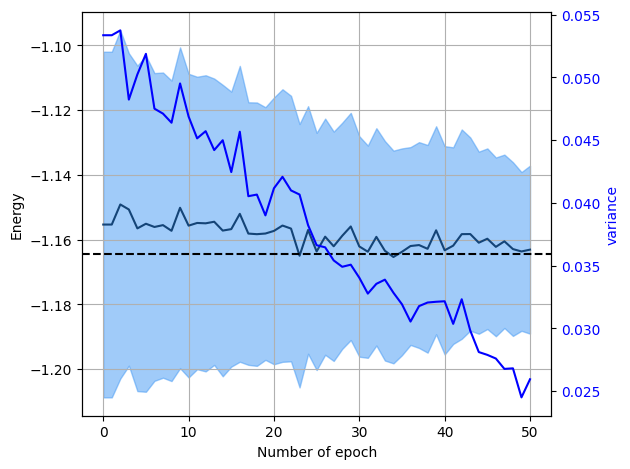

In [14]:
plot_energy(obs.local_energy, e0=-1.1645, show_variance=True)